# Lasso Polynomial Regression

### Load Data

In [181]:
import pandas as pd
import numpy as np
import seaborn as sns
trees = pd.read_csv('../categorized_data.csv')
len(trees)
trees['season'] = pd.cut(trees['mo'], bins=[-0.5, 3.5, 6.5, 9.5, 12.5], labels=['winter', 'spring', 'summer', 'fall'])
trees['mo_cos'] = np.cos(2 * np.pi * trees['mo'] / 12)
trees['mo_sin'] = np.sin(2 * np.pi * trees['mo'] / 12)
# trees['growth_2'] = pd.cut(trees['change_basal_area'], bins=[-0.5, 0, 0.07, 0.23, 1000], labels=['No Growth', 'Little Growth', 'Moderate Growth', 'Extreme Growth'])
# trees['growth_category'] = trees['growth_category'].replace({'No Growth': 'A Little Growth'})
trees['growth_pct'] = trees['change_basal_area'] / (trees['average_basal_area'] - trees['change_basal_area'])
trees.head().T

,0,1,2,3,4
Unnamed: 0,1,2,4,5,7
site,AK,AK,AK,AK,AK
tree,1A,1A,1A,1A,1A
plot,1,1,1,1,1
species,P glauca,P glauca,P glauca,P glauca,P glauca
Date,2019-01-01,2019-02-01,2019-05-01,2019-06-01,2018-07-01
longitude,-149.71571,-149.71571,-149.71571,-149.71571,-149.71571
latitude,68.018576,68.018576,68.018576,68.018576,68.018576
da,1,1,1,1,1
mo,1,2,5,6,7


In [169]:
trees.columns

Index(['Unnamed: 0', 'site', 'tree', 'plot', 'species', 'Date', 'longitude',
       'latitude', 'da', 'mo', 'wk', 'yr', 'average_stem_radius',
       'change_stem_radius', 'average_basal_area', 'change_basal_area',
       'average_air_temperature', 'average_air_pressure', 'average_humidity',
       'avg_solar_irradiance', 'avg_soil_water_content', 'freeze_flag',
       'air_pressure_cat', 'humidity_cat', 'solar_rank', 'solar_cat',
       'soil_moist_cat', 'growth_category', 'season', 'mo_cos', 'mo_sin',
       'growth_pct'],
      dtype='object')

count    13637.000000
mean         0.001930
std          0.001835
min          0.000000
25%          0.000674
50%          0.001472
75%          0.002648
max          0.021515
Name: growth_pct, dtype: float64


<Axes: xlabel='growth_pct', ylabel='Density'>

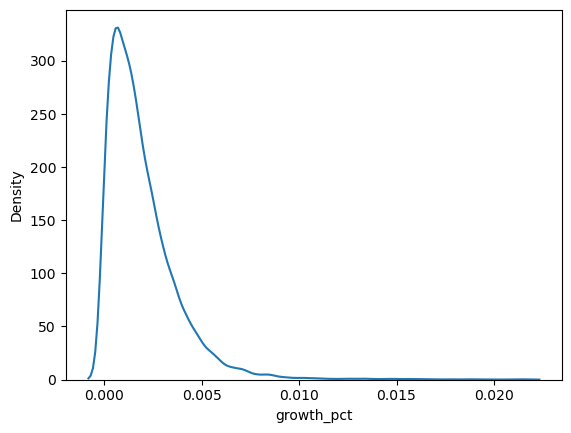

In [182]:
print(trees['growth_pct'].describe())
sns.kdeplot(data=trees['growth_pct'])

### chatgpt lasso

In [183]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor

target_col = 'growth_pct'
cat_cols = [
    'species','freeze_flag','season', 'site'
]
num_cols = [
    'latitude',
    'longitude',
    'yr',
    'average_air_temperature', 
    'average_air_pressure',
    'average_humidity',
    'avg_solar_irradiance', 
    'avg_soil_water_content',
    'mo_cos',
    'average_stem_radius',
]

y = trees[target_col]
X = trees[cat_cols + num_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False), cat_cols)
    ]
)

# Full pipeline with polynomial features
pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(
        degree=2,
        include_bias=False,
        interaction_only=False
    )),
    ("lasso", LassoCV(cv=5, max_iter=20000, random_state=42))
])

# model = TransformedTargetRegressor(
#     regressor=pipe,
#     transformer=PowerTransformer(method="yeo-johnson", standardize=True)
# )

# Fit
pipe.fit(X_train, y_train)
print("Best alpha:", pipe.named_steps["lasso"].alpha_)
# model.fit(X_train, y_train)
# print("Best alpha:", model.regressor_.named_steps["lasso"].alpha_)


Best alpha: 7.407429341377264e-07


In [184]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred = pipe.predict(X_test)

print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R²: 0.363825765298757
RMSE: 0.0015039141144436844


In [126]:
import pandas as pd

preprocess_feature_names = model.regressor_.named_steps["preprocess"].get_feature_names_out()
feature_names = model.regressor_.named_steps["poly"].get_feature_names_out(
    preprocess_feature_names
)
coefs = model.regressor_.named_steps["lasso"].coef_

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefs
})

coef_df = coef_df.sort_values("coefficient", key=abs, ascending=False)
coef_df

,feature,coefficient
1,num__longitude,0.898883
18,num__latitude num__average_air_temperature,0.695636
0,num__latitude,-0.661198
103,num__avg_soil_water_content cat__season_spring,-0.597596
32,num__longitude num__average_air_temperature,-0.563894
...,...,...
130,cat__season_summer cat__season_winter,0.000000
131,cat__season_summer cat__site_NWT,0.000000
132,cat__season_winter^2,0.000000
133,cat__season_winter cat__site_NWT,0.000000


In [114]:
air_temp = 6.29305556085375 + 0.5
soil_water = 0.358025874981519 + 0.2
check = pd.DataFrame([20,'AK','1A',1,'P glauca','2018-07-02',-149.71571,68.0185764,2,7,27,2018,10.5434722222222,0.0060000000000002,349.234548426577,0.39742403705003,air_temp,93.9599012798733,0.798147046731578,73.5775629679362,soil_water,0,'medium','dry',10513.0,'Q3','wet','A Lot of Growth']).T
check.columns = ['Unnamed: 0','site','tree','plot','species','Date','longitude','latitude','da','mo','wk','yr','average_stem_radius','change_stem_radius','average_basal_area','change_basal_area','average_air_temperature','average_air_pressure','average_humidity','avg_solar_irradiance','avg_soil_water_content','freeze_flag','air_pressure_cat','humidity_cat','solar_rank','solar_cat','soil_moist_cat','growth_category']
check['mo_cos'] = np.cos(2 * np.pi * trees['mo'] / 12)
check['mo_sin'] = np.sin(2 * np.pi * trees['mo'] / 12)
check['season'] = 'summer'
check_X = check[cat_cols + num_cols]
model.predict(check_X)[0]

np.float64(-0.009168517227041262)

### chatgpt elastic net

In [63]:
from sklearn.linear_model import ElasticNetCV

enet_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("poly", PolynomialFeatures(
        degree=2,
        include_bias=False,
        interaction_only=True
    )),
    ("enet", ElasticNetCV(
        l1_ratio=[.01, .05, .1,  .3,  .5,  .7, .9, .95],   # 1.0 = Lasso-like
        cv=5,
        max_iter=10000,
        random_state=42
    ))
])

enet_model = TransformedTargetRegressor(
    regressor=enet_pipe,
    transformer=PowerTransformer(method="yeo-johnson", standardize=True)
)

enet_model.fit(X_train, y_train)

y_pred = enet_model.predict(X_test)

print("ElasticNet best alpha:", enet_model.regressor_.named_steps["enet"].alpha_)
print("ElasticNet best l1_ratio:", enet_model.regressor_.named_steps["enet"].l1_ratio_)
print("ElasticNet R²:", enet_model.regressor_.score(X_test, y_test))
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

ElasticNet best alpha: 0.0002973987358219516
ElasticNet best l1_ratio: 0.95
ElasticNet R²: -6.473530880531697
R²: 0.03508231263639916
RMSE: 0.16244475471540895


In [64]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# inverse-transformed predictions (what users usually look at)
y_pred_orig = enet_model.predict(X_test)

# original-scale metrics
r2_orig = r2_score(y_test, y_pred_orig)
rmse_orig = np.sqrt(mean_squared_error(y_test, y_pred_orig))

# transformed-space predictions & true y
y_test_t = model.transformer_.transform(y_test.values.reshape(-1, 1)).ravel()
y_pred_t = model.regressor_.predict(X_test)   # regressor_ predicts in transformed space

r2_trans = r2_score(y_test_t, y_pred_t)
rmse_trans = np.sqrt(mean_squared_error(y_test_t, y_pred_t))

print(f"Original-scale R²: {r2_orig:.4f}, RMSE: {rmse_orig:.4f}")
print(f"Transformed-space R²: {r2_trans:.4f}, RMSE: {rmse_trans:.4f}")


Original-scale R²: 0.0351, RMSE: 0.1624
Transformed-space R²: 0.2475, RMSE: 0.8817


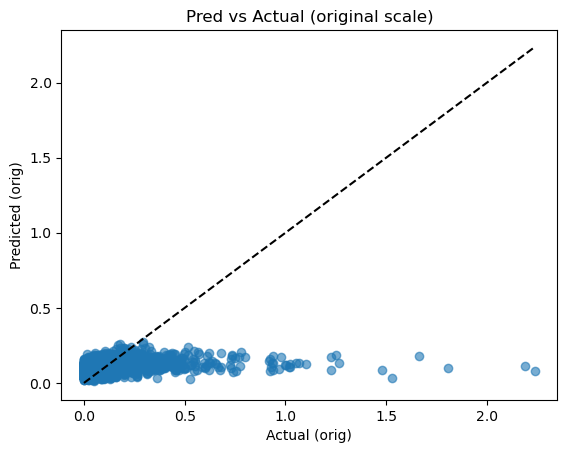

In [65]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred_orig, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual (orig)")
plt.ylabel("Predicted (orig)")
plt.title("Pred vs Actual (original scale)")
plt.show()


In [66]:
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import GridSearchCV

def r2_orig_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    return r2_score(y, y_pred)

scorer = make_scorer(r2_orig_scorer, greater_is_better=True)

def r2_orig_scorer(estimator, X, y):
    y_pred = estimator.predict(X)
    from sklearn.metrics import r2_score
    return r2_score(y, y_pred)

param_grid = {
    "regressor__enet__l1_ratio": [.01, .05, .1,  .3,  .5,  .7, .9, .95]
}

grid = GridSearchCV(enet_model, param_grid=param_grid, scoring=r2_orig_scorer, cv=5)
grid.fit(X_train, y_train)


,estimator,TransformedTa...Transformer())
,param_grid,"{'regressor__enet__l1_ratio': [0.01, 0.05, ...]}"
,scoring,<function r2_...0021C5E801BC0>
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [69]:
import plotly.express as px
results_df = pd.DataFrame(grid.cv_results_)
results_df
# fig = px.line(
#     results_df,
#     x='k',
#     y='mean_score',
#     markers=True,
#     labels={'k': 'Number of Neighbors (k)', 'mean_score': 'Mean CV Balanced Accuracy'}
# )

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__enet__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.109182,0.002807,0.005078,0.000573,0.01,{'regressor__enet__l1_ratio': 0.01},0.047321,0.041018,0.000118,0.021963,0.045290,0.031142,0.017923,8
1,0.139976,0.025106,0.005128,0.000419,0.05,{'regressor__enet__l1_ratio': 0.05},0.051185,0.047909,0.003975,0.027058,0.051085,0.036242,0.018467,7
2,0.141028,0.003967,0.004945,0.000668,0.10,{'regressor__enet__l1_ratio': 0.1},0.051993,0.049532,0.004814,0.028363,0.052397,0.037420,0.018593,6
3,0.147642,0.006067,0.004873,0.000445,0.30,{'regressor__enet__l1_ratio': 0.3},0.052644,0.050863,0.005495,0.029475,0.053553,0.038406,0.018709,5
4,0.150290,0.001796,0.005065,0.000730,0.50,{'regressor__enet__l1_ratio': 0.5},0.052798,0.051143,0.005661,0.029716,0.053814,0.038627,0.018731,4
5,0.152553,0.004342,0.004849,0.000435,0.70,{'regressor__enet__l1_ratio': 0.7},0.052867,0.051264,0.005734,0.029823,0.053929,0.038723,0.018741,3
6,0.150473,0.003807,0.004890,0.000386,0.90,{'regressor__enet__l1_ratio': 0.9},0.052901,0.051331,0.005775,0.029882,0.053993,0.038776,0.018745,2
7,0.147548,0.005464,0.005057,0.000408,0.95,{'regressor__enet__l1_ratio': 0.95},0.052907,0.051344,0.005782,0.029893,0.054005,0.038786,0.018746,1


### model sim

In [187]:
sim_model = pipe

tree_year = trees.copy().query("tree == '1B' and yr == 2018")
print(len(tree_year))

real_growth = sum(tree_year['growth_pct'])

sim_year = sim_model.predict(tree_year[num_cols + cat_cols])
simulated_growth = sum(sim_year)

temp_changes = [-1,0,1,2,3]
water_changes = [-.2,-.1,0,.1,.2,.3]
humidity_changes = [-.2,-.1,0,.1,.2,.3]

# df to store the results
results_df = pd.DataFrame(columns=['temp_change', 'water_change', 'simulated_growth'])

for temp_change in temp_changes:
    for water_change in water_changes:
        mod_copy = tree_year.copy()
        mod_copy['average_air_temperature'] = mod_copy['average_air_temperature'] + temp_change
        mod_copy['avg_soil_water_content'] = mod_copy['avg_soil_water_content'] + water_change
        mod_copy['average_humidity'] = mod_copy['average_humidity'] + 0.1
        mod_sim_year = sim_model.predict(mod_copy[num_cols + cat_cols])
        mod_simulated_growth = sum(mod_sim_year)
        results_df = pd.concat([results_df, pd.DataFrame({'temp_change': temp_change, 'water_change': water_change, 'simulated_growth': mod_simulated_growth}, index=[0])], ignore_index=True)
results_df.pivot_table(index='temp_change', columns='water_change', values='simulated_growth').round(4)

# tree_year['average_air_temperature'] = tree_year['average_air_temperature'] + 1
# tree_year['avg_soil_water_content'] = tree_year['avg_soil_water_content'] + .1
# mod_sim_year = sim_model.predict(tree_year[num_cols + cat_cols])
# mod_simulated_growth = sum(mod_sim_year)

# print(f"Real growth: {real_growth}")
# print(f"Simulated growth: {simulated_growth}")
# print(f"Modified simulated growth: {mod_simulated_growth}")


155


C:\Users\seths\AppData\Local\Temp\ipykernel_29880\15230819.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'temp_change': temp_change, 'water_change': water_change, 'simulated_growth': mod_simulated_growth}, index=[0])], ignore_index=True)


water_change,-0.2,-0.1,0.0,0.1,0.2,0.3
temp_change,,,,,,
-1,0.5365,0.4606,0.4060,0.3726,0.3605,0.3696
0,0.5315,0.4552,0.4001,0.3663,0.3537,0.3623
1,0.5295,0.4527,0.3971,0.3628,0.3497,0.3579
2,0.5303,0.4530,0.3970,0.3622,0.3487,0.3564
3,0.5340,0.4562,0.3998,0.3645,0.3505,0.3577
